# AoA-Taper 2D Surrogate on Forces 

This notebook contains the data filtering and error assessment of various 2D surrogates including polynomial and radial basis functions.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd
#from scipy.interpolate import RBFInterpolator
from scipy.interpolate import Rbf
import linear_regression as lr

In [2]:
foldername = 'aoa_taper_forces'
cwd = os.getcwd()
os.chdir(cwd+'/'+foldername+'/')
data_pandas = pd.read_csv(foldername+'.csv') 
# Go back to the initial folder
os.chdir(cwd)
design_para = 'taper'

In [3]:
data_numpy = data_pandas.to_numpy()
AoA_deg = data_numpy[:,2]
AR      = data_numpy[:,3]
taper   = data_numpy[:,4]
lift    = data_numpy[:,5]
drag    = data_numpy[:,6]
my      = data_numpy[:,7]
print(type(data_numpy[:,1]))
print(data_numpy[:,1])
data_pandas.head()

<class 'numpy.ndarray'>
['0_0_0' '1_0_0' '2_0_0' '3_0_0' '4_0_0' '5_0_0' '6_0_0' '0_0_1' '1_0_1'
 '2_0_1' '3_0_1' '4_0_1' '5_0_1' '6_0_1' '0_0_2' '1_0_2' '2_0_2' '3_0_2'
 '4_0_2' '5_0_2' '6_0_2' '0_0_3' '1_0_3' '2_0_3' '3_0_3' '4_0_3' '5_0_3'
 '6_0_3' '0_0_4' '1_0_4' '2_0_4' '3_0_4' '4_0_4' '5_0_4' '6_0_4' '0_0_5'
 '1_0_5' '2_0_5' '3_0_5' '4_0_5' '5_0_5' '6_0_5' '0_0_6' '1_0_6' '2_0_6'
 '3_0_6' '4_0_6' '5_0_6' '6_0_6']


,Unnamed: 0,label,AoA_deg,ar,taper,lift,drag,my
0,0,0_0_0,0.0,32.0,0.2,1.237444e-11,2.976598e-26,1.426616e-12
1,1,1_0_0,0.6,32.0,0.2,1.332874e+02,1.046098e-01,8.175629e+00
2,2,2_0_0,1.2,32.0,0.2,2.622454e+02,4.097354e-01,1.615639e+01
3,3,3_0_0,1.8,32.0,0.2,3.850371e+02,9.003635e-01,2.384927e+01
4,4,4_0_0,2.4,32.0,0.2,5.008208e+02,1.557728e+00,3.121110e+01


## Filter points into training and testing

In [4]:
num_models = len(data_numpy[:,1])
i_train = np.arange(0,num_models+1,2)
i_test = np.arange(1,num_models,2)
x1 = AoA_deg[i_train]
x1_test = AoA_deg[i_test]
x2 = taper[i_train]
x2_test = taper[i_test]
lift_train= lift[i_train]
lift_test = lift[i_test]
drag_train= drag[i_train]
drag_test = drag[i_test]
print('num of training points = ',len(i_train))
print('num of testing points = ',len(i_test))

num of training points =  25
num of testing points =  24


Text(0.5, 0, 'Taper')

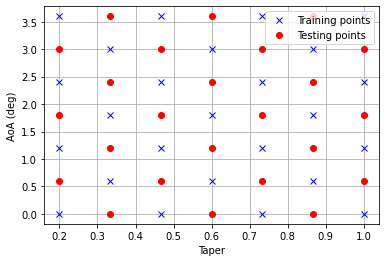

In [5]:
# Plot the points used
fig1, ax = plt.subplots()

ax.plot(x2,x1,'bx')
ax.plot(x2_test,x1_test,'ro')


ax.legend(["Training points","Testing points"])
ax.grid(True)
ax.set_ylabel('AoA (deg)')
ax.set_xlabel('Taper')


## Lift 2D surrogate

To validate the lift, we will include the lift produced by a flat plate rigid wing given by Anderson Ch5. Pg 456:
$$a = \frac{a_0}{1+(a_0/\pi AR)(1+\tau)}$$ 

Where the value of $\tau$ is typically between 0.05 and 0.25

In [6]:
def lift_analytic(AoA_deg,dCldalpha2D,AR,tau,q,Sref):
    """ Function to calculate lift using analytic equation
    
    Args:
        AoA_deg   (np.array): Angle of attack in degrees
        dCldalpha2D (float): Lift curve slope of the 2D section in 1/rad
        AR (float): Aspect ratio
        tau (float): Efficiency parameter
        
    Returns:
        lift (np.array): Lift in N calculated at each AoA"""
    
    # Add tail parameters
    AR_tail = 10
    S_tail = 2.5
    
    dCldalpha_tail = dCldalpha2D/(1+dCldalpha2D/(np.pi*AR_tail)*(1+tau))
    AoA_rad = AoA_deg*np.pi/180
    dCldalpha = dCldalpha2D/(1+dCldalpha2D/(np.pi*AR)*(1+tau))
    lift = (dCldalpha+dCldalpha_tail*S_tail/Sref)*AoA_rad*q*Sref
    return lift


Text(0.5, 0, 'AoA (deg)')

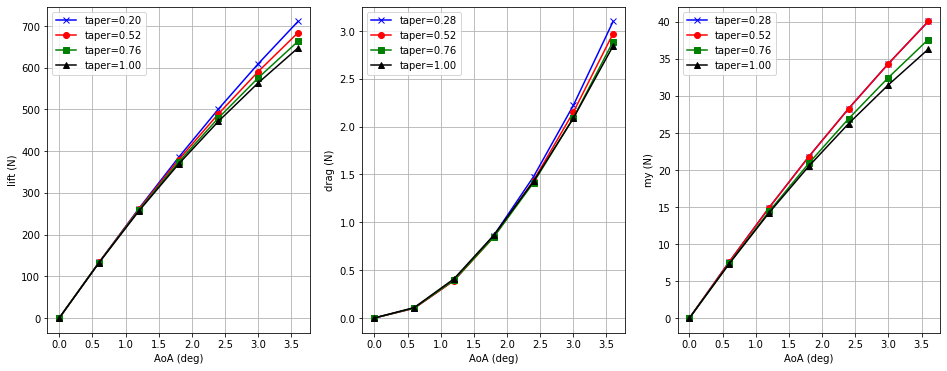

In [7]:
# Plot lift for different taper ratio's
x = AoA_deg[0:7]
lift0 = lift[0:7]
lift1 = lift[7:14]
lift2 = lift[14:21]
lift3 = lift[21:28]
lift4 = lift[28:35]
lift5 = lift[35:42]
lift6 = lift[42:49]

drag0 = drag[0:7]
drag1 = drag[7:14]
drag2 = drag[14:21]
drag3 = drag[21:28]
drag4 = drag[28:35]
drag5 = drag[35:42]
drag6 = drag[42:49]

my0 = my[0:7]
my1 = my[7:14]
my2 = my[14:21]
my3 = my[21:28]
my4 = my[28:35]
my5 = my[35:42]
my6 = my[42:49]


fig2, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

ax[0].plot(x,lift0,'bx-')
ax[0].plot(x,lift2,'ro-')
ax[0].plot(x,lift4,'gs-')
ax[0].plot(x,lift6,'k^-')


ax[0].legend(["taper=0.20","taper=0.52","taper=0.76","taper=1.00"])
ax[0].grid(True)
ax[0].set_ylabel('lift (N)')
ax[0].set_xlabel('AoA (deg)')


ax[1].plot(x,drag1,'bx-')
ax[1].plot(x,drag2,'ro-')
ax[1].plot(x,drag4,'gs-')
ax[1].plot(x,drag6,'k^-')


ax[1].legend(["taper=0.28","taper=0.52","taper=0.76","taper=1.00"])
ax[1].grid(True)
ax[1].set_ylabel('drag (N)')
ax[1].set_xlabel('AoA (deg)')

ax[2].plot(x,my2,'bx-')
ax[2].plot(x,my2,'ro-')
ax[2].plot(x,my4,'gs-')
ax[2].plot(x,my6,'k^-')


ax[2].legend(["taper=0.28","taper=0.52","taper=0.76","taper=1.00"])
ax[2].grid(True)
ax[2].set_ylabel('my (N)')
ax[2].set_xlabel('AoA (deg)')



## Fit a 1D surrogate to the data

Test at $\alpha = 1.2^o$ which is the best surrogate to use. 


Text(0.5, 0, 'taper')

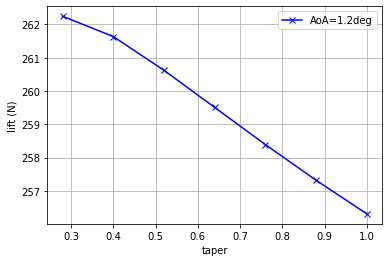

In [8]:
# Find the index positions where AoA_deg = 1.2
AoA_target = 1.2
indices = np.where(AoA_deg == AoA_target)
lift_target = lift[indices]
taper_values = np.linspace(0.28,1.0,7)

AoA_target2 = 3.6
indices2 = np.where(AoA_deg == AoA_target2)
lift_target2 = lift[indices2]
taper_values = np.linspace(0.28,1.0,7)
fig3, ax = plt.subplots()

ax.plot(taper_values,lift_target,'bx-')

ax.legend(["AoA=1.2deg","AoA=3.6deg"])
ax.grid(True)
ax.set_ylabel('lift (N)')
ax.set_xlabel('taper')


1st = 0.025182489780087604
2nd = 0.018362665256060336
3rd = 0.0027462471286787992
4th = 0.003680201046056227
linear       = 0.013953333992415598
Multiquadric = 29.469251306642423
Gaussian     = 104.1767865105337
Cubic        = 1400.52410459817


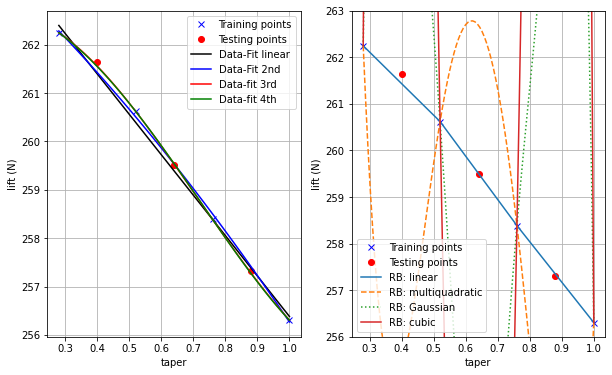

In [9]:
# Build surrogate using training data
i_test = [1,3,5]
i_train = [0,2,4,6]
x = taper_values[i_train]
y = lift_target[i_train]
x_test = taper_values[i_test]
y_test = lift_target[i_test]
points_train = {
    'x' : taper_values[i_train],
    'y' : lift_target[i_train]
}
points_test = {
    'x' : taper_values[i_test],
    'y' : lift_target[i_test]
}
x = [0.28, 0.52, 0.76, 1.  ]
y = [262.2454492117006, 260.6201354629081, 258.3874823220024, 256.305061150681]

# Polynomial surrogates on lift
surr1 = lr.Polynomial(1,points_train,points_test)
surr1.build()
surr2 = lr.Polynomial(2,points_train,points_test)
surr2.build()
surr3 = lr.Polynomial(3,points_train,points_test)
surr3.build()
surr4 = lr.Polynomial(4,points_train,points_test)
surr4.build()


# Radial Basis functions on lift
surr_rb_l = Rbf(x,y, function = 'linear')
surr_rb_m = Rbf(x,y, function = 'multiquadric')
surr_rb_g = Rbf(x,y, function = 'gaussian')
surr_rb_c = Rbf(x,y, function = 'cubic')


xp = np.linspace(0.28,1.0,100)
lift_p1 = surr1.eval_surrogate(xp)
lift_p2 = surr2.eval_surrogate(xp)
lift_p3 = surr3.eval_surrogate(xp)
lift_p4 = surr4.eval_surrogate(xp)

# Plot the points on the graph
fig4, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

ax[0].plot(x,y,'bx')
ax[0].plot(x_test,y_test,'ro')
ax[0].plot(xp,lift_p1,'k-')
ax[0].plot(xp,lift_p2,'b-')
ax[0].plot(xp,lift_p3,'r-')
ax[0].plot(xp,lift_p4,'g-')
# ax.plot(xp,yp4,'--')
# ax.plot(xp,ynp2,'x')
# ax.plot(xp,ynp3,'o')
# ax.plot(xp,ynp4,'^')

ax[0].legend(["Training points","Testing points","Data-Fit linear","Data-Fit 2nd","Data-fit 3rd","Data-fit 4th"])
ax[0].grid(True)
ax[0].set_ylabel('lift (N)')
ax[0].set_xlabel(design_para)
plt.ylim([256,263])

ax[1].plot(x,y,'bx')
ax[1].plot(x_test,y_test,'ro')
ax[1].plot(xp,surr_rb_l(xp),'-')
ax[1].plot(xp,surr_rb_m(xp),'--')
ax[1].plot(xp,surr_rb_g(xp),':')
ax[1].plot(xp,surr_rb_c(xp),'-')

ax[1].legend(["Training points","Testing points","RB: linear","RB: multiquadratic","RB: Gaussian",'RB: cubic'])
ax[1].grid(True)
ax[1].set_ylabel('lift (N)')
ax[1].set_xlabel(design_para)

ax[1].set_ylim([256,263])
# check errors
print('1st =', surr1.eval_error())
print('2nd =', surr2.eval_error())
print('3rd =', surr3.eval_error())
print('4th =', surr4.eval_error())

error_l = 0
error_m = 0
error_g = 0
error_c = 0
for i in range(len(x_test)):
    error_l += (surr_rb_l(x_test[i])-y_test[i])**2
    error_m += (surr_rb_m(x_test[i])-y_test[i])**2
    error_g += (surr_rb_g(x_test[i])-y_test[i])**2
    error_c += (surr_rb_c(x_test[i])-y_test[i])**2
error_l = error_l/len(x_test)
error_m = error_m/len(x_test)
error_g = error_g/len(x_test)
error_c = error_c/len(x_test)

print('linear       =', error_l)
print('Multiquadric =', error_m)
print('Gaussian     =', error_g)
print('Cubic        =',error_c)

# Could check what happens at higher AoA's

### Drag

Text(0.5, 0, 'taper')

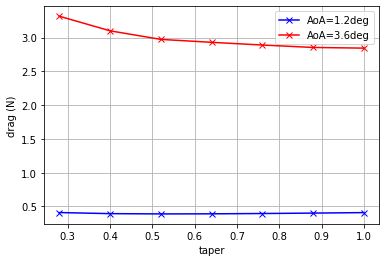

In [10]:
drag_target = drag[indices]

drag_target2 = drag[indices2]

fig4, ax = plt.subplots()

ax.plot(taper_values,drag_target,'bx-')
ax.plot(taper_values,drag_target2,'rx-')

ax.legend(["AoA=1.2deg","AoA=3.6deg"])
ax.grid(True)
ax.set_ylabel('drag (N)')
ax.set_xlabel('taper')


1st = 4.882952067613376e-05
2nd = 9.809418612670422e-06
3rd = 1.0336896466772074e-06
4th = 2.1549816740669058e-06
linear       = 1.2624903907953932e-05
Multiquadric = 3.889772246075162e-05
Gaussian     = 0.00035974023733874273
Cubic        = 0.003182521856253326


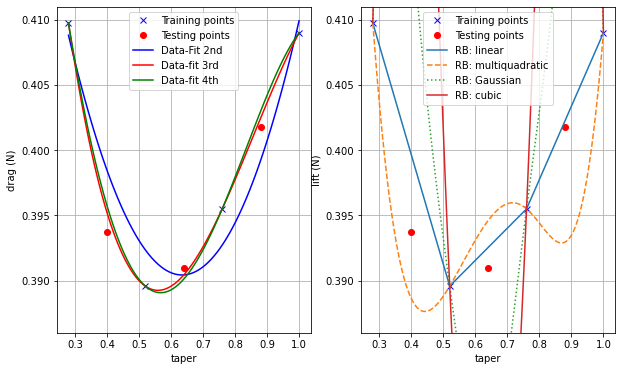

In [11]:
# Build surrogate using training data
x = taper_values[i_train]
y = drag_target[i_train]
x_test = taper_values[i_test]
y_test = drag_target[i_test]
points_train = {
    'x' : taper_values[i_train],
    'y' : drag_target[i_train]
}
points_test = {
    'x' : taper_values[i_test],
    'y' : drag_target[i_test]
}

# Store in the way required by 
d_surr1 = lr.Polynomial(1,points_train,points_test)
d_surr1.build()
d_surr2 = lr.Polynomial(2,points_train,points_test)
d_surr2.build()
d_surr3 = lr.Polynomial(3,points_train,points_test)
d_surr3.build()
d_surr4 = lr.Polynomial(4,points_train,points_test)
d_surr4.build()

x = [0.28, 0.52, 0.76, 1.  ]
y = [0.4097354164206015, 0.389578448044829, 0.3954987179129068, 0.408989759326281]
xp = np.linspace(0.28,1.0,100)
drag_p1 = d_surr1.eval_surrogate(xp)
drag_p2 = d_surr2.eval_surrogate(xp)
drag_p3 = d_surr3.eval_surrogate(xp)
drag_p4 = d_surr4.eval_surrogate(xp)

# Radial Basis functions on drag
d_surr_rb_l = Rbf(x,y, function = 'linear')
d_surr_rb_m = Rbf(x,y, function = 'multiquadric')
d_surr_rb_g = Rbf(x,y, function = 'gaussian')
d_surr_rb_c = Rbf(x,y, function = 'cubic')
# Plot the points on the graph
fig5, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

ax[0].plot(x,y,'bx')
ax[0].plot(x_test,y_test,'ro')
ax[0].plot(xp,drag_p2,'b-')
ax[0].plot(xp,drag_p3,'r-')
ax[0].plot(xp,drag_p4,'g-')
# ax.plot(xp,yp4,'--')
# ax.plot(xp,ynp2,'x')
# ax.plot(xp,ynp3,'o')
# ax.plot(xp,ynp4,'^')

ax[0].legend(["Training points","Testing points","Data-Fit 2nd","Data-fit 3rd","Data-fit 4th"])
ax[0].grid(True)
ax[0].set_ylabel('drag (N)')
ax[0].set_xlabel(design_para)
ax[0].set_ylim([0.386,0.411])
ax[1].plot(x,y,'bx')
ax[1].plot(x_test,y_test,'ro')
ax[1].plot(xp,d_surr_rb_l(xp),'-')
ax[1].plot(xp,d_surr_rb_m(xp),'--')
ax[1].plot(xp,d_surr_rb_g(xp),':')
ax[1].plot(xp,d_surr_rb_c(xp),'-')

ax[1].legend(["Training points","Testing points","RB: linear","RB: multiquadratic","RB: Gaussian",'RB: cubic'])
ax[1].grid(True)
ax[1].set_ylabel('lift (N)')
ax[1].set_xlabel(design_para)
ax[1].set_ylim([0.386,0.411])
# check errors
print('1st =', d_surr1.eval_error())
print('2nd =', d_surr2.eval_error())
print('3rd =', d_surr3.eval_error())
print('4th =', d_surr4.eval_error())

d_error_l = 0
d_error_m = 0
d_error_g = 0
d_error_c = 0
for i in range(len(x_test)):
    d_error_l += (d_surr_rb_l(x_test[i])-y_test[i])**2
    d_error_m += (d_surr_rb_m(x_test[i])-y_test[i])**2
    d_error_g += (d_surr_rb_g(x_test[i])-y_test[i])**2
    d_error_c += (d_surr_rb_c(x_test[i])-y_test[i])**2
d_error_l = d_error_l/len(x_test)
d_error_m = d_error_m/len(x_test)
d_error_g = d_error_g/len(x_test)
d_error_c = d_error_c/len(x_test)

print('linear       =', d_error_l)
print('Multiquadric =', d_error_m)
print('Gaussian     =', d_error_g)
print('Cubic        =',d_error_c)

# Could check what happens at higher AoA's

## Save errors from 1D case

In [12]:
surr_type = ['2nd','3rd','4th','linear','Multiquadric','Gaussian','Cubic']
lift_err  = [surr2.eval_error(),surr3.eval_error(),surr4.eval_error(),error_l,error_m,error_g,error_c]
drag_err  = [d_surr2.eval_error(),d_surr3.eval_error(),d_surr4.eval_error(),d_error_l,d_error_m,d_error_g,d_error_c]

error_data = {
    "surr_type": surr_type,
    "lift_err": lift_err,
    "drag_err": drag_err
}

error_data_pandas = pd.DataFrame(error_data)
error_data_pandas.to_csv(foldername+'_error.csv')

## Lift 2D surrogate

In [13]:
os.getcwd()

'/home/pablodfs/FYP/Projects-SHARPy/aeroelasticPMOR_Optimization/surrogate_model'

In [14]:
def polynomial_basis2D(x,y,kx,ky):
    """Evaluates a vector using a kth degree polynomial in two directions.

    Args:
        x (np.array): Vector of points to be evaluated 
        y (np.array): Vector of points to be evaluated
        kx     (int): Degree polynomial in variable x
        ky     (int): Degree polynomial in varibale y
    Returns:
        b (np.array): 2D array with evaluations of x,y for every point

    """
    num = x.size
    num2 = y.size
    if num != num2:
        print('Vectors x and y must be the same size')
    else:
        b = np.zeros([num,(kx+1)*(ky+1)])
        for k in range(num):
            counter = 0
            for i in range(kx+1):
                for j in range(ky+1):
                    b[k,counter] = x[k]**(i)*y[k]**(j)
                    counter+=1
    return b


In [54]:
i_train = np.arange(0,num_models+1,2)
i_test = np.arange(1,num_models,2)
#test the function
x = x1
y = x2
kx = 2 # Variation of lift with AoA
ky = 4 # Variation of lift with twist
b = polynomial_basis2D(x,y,kx,ky)
print(x1)
print(len(x2))
print(len(lift[i_train]))

[0.0 1.2 2.4 3.6 0.6 1.7999999999999998 3.0 0.0 1.2 2.4 3.6 0.6
 1.7999999999999998 3.0 0.0 1.2 2.4 3.6 0.6 1.7999999999999998 3.0 0.0 1.2
 2.4 3.6]
25
25


In [55]:
def eval_parameter(f,b):
    """ Function evaluates a theta matrix which solves a least squares
    problem: [theta]=[B^+]{f} where [B^+] is the Moore-Penrose Pseudo Inverse
    These points can then be used to evaluate the polynomial via:
    f(x) = theta[0]*b[0]+theta[1]*b[1]+...+theta[k+1]*b[k+1]"""

    y     = np.matrix(f).T # Use a column vector
    bpinv = np.matrix(np.linalg.pinv(b)) # calculate the pseudo inverse
    theta = bpinv*y
    return theta

In [56]:
theta = eval_parameter(lift[i_train],b)
print(theta)
print('\n')
print(theta.shape)

[[17.14117264905383]
 [-162.9290779355821]
 [484.03421430083745]
 [-574.2983602313934]
 [236.16180775979205]
 [208.0285013367233]
 [202.54100057444793]
 [-581.0218476863338]
 [675.9928202884439]
 [-275.55648165791354]
 [-1.8344321642868522]
 [-58.80202244582779]
 [143.0736945853705]
 [-162.63373060745653]
 [66.23662551844836]]


(15, 1)


In [40]:
def eval_surrogate(theta,x,y,kx,ky):
    """ Function which evaluates the surrogate function

    Args:
        x (np.array): Points at which surrogate output is seeked
        y (np.array): Second dimension of points to evaluate surrogate at
        kx     (int): Degree polynomial in variable x
        ky     (int): Degree polynomial in varibale y
    Returns
        f (np.array): Evaluations of the surrogate
    """
    f = np.zeros([len(x), ])
    params = theta
    for i in range(len(x)):
        btest = polynomial_basis2D(np.array([x[i]]),np.array([y[i]]),kx,ky)
        f[i] = np.dot(btest, params)

    return f


In [41]:
xp = np.linspace(0,3.6,100)
yp0 = taper[0]*np.ones(xp.shape)
yp1 = taper[7]*np.ones(xp.shape)
yp2 = taper[14]*np.ones(xp.shape)
yp3 = taper[21]*np.ones(xp.shape)
yp4 = taper[28]*np.ones(xp.shape)
yp5 = taper[35]*np.ones(xp.shape)
yp6 = taper[42]*np.ones(xp.shape)

lift0surr = eval_surrogate(theta,xp,yp0,kx,ky)
lift1surr = eval_surrogate(theta,xp,yp1,kx,ky)
lift2surr = eval_surrogate(theta,xp,yp2,kx,ky)
lift3surr = eval_surrogate(theta,xp,yp3,kx,ky)
lift4surr = eval_surrogate(theta,xp,yp4,kx,ky)
lift5surr = eval_surrogate(theta,xp,yp5,kx,ky)
lift6surr = eval_surrogate(theta,xp,yp6,kx,ky)

Text(0.5, 0, 'AoA (deg)')

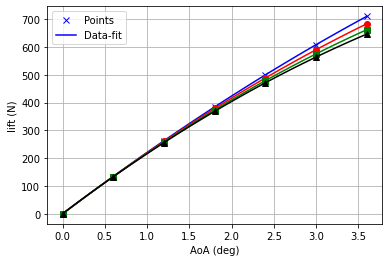

In [42]:
# Plot lift for different AR's
x = AoA_deg[0:7]
# lift0 = lift[0:7]
# lift1 = lift[7:14]
# lift2 = lift[14:21]
# lift3 = lift[21:28]
# lift4 = lift[28:35]
# lift5 = lift[35:42]
# lift6 = lift[42:49]

fig3, ax = plt.subplots()

ax.plot(x,lift0,'bx')
ax.plot(xp,lift0surr,'b-')
ax.plot(x,lift2,'ro')
ax.plot(xp,lift2surr,'r-')
ax.plot(x,lift4,'gs')
ax.plot(xp,lift4surr,'g-')
ax.plot(x,lift6,'k^')
ax.plot(xp,lift6surr,'k-')

ax.legend(["Points","Data-fit"])
ax.grid(True)
ax.set_ylabel('lift (N)')
ax.set_xlabel('AoA (deg)')

## Obtain the errors

In [43]:
def eval_error(f_test,theta,x_test,y_test,kx,ky):
    """ Function to evaluate the error in a model
    
    eval_errors(f_test,theta,x_test,y_test,kx,ky) calculates
    the means squared error from a set of 2D testing points with 
    outputs f_test
    
    Args:
        f_test  (np.array): True testing outputs from the model
        theta   (np.array): Parameters from the surrogate
        x_test  (np.array): Testing points from the first design parameter
        y_test  (np.array): Testing points from the second design parameter
        kx     (int): Degree polynomial in variable x
        ky     (int): Degree polynomial in varibale y
    Returns:
        error   (float): Mean squared error

    """
    error=0 # Initialize the error
    f_surr = eval_surrogate(theta,x_test,y_test,kx,ky)
    for i in range(len(f_test)):
        error+=(f_test[i]-f_surr[i])**2
    error = error/len(f_test)
    
    return error
        

In [44]:
error_lift = eval_error(lift_test,theta,x1_test,x2_test,kx,ky)
print(error_lift)

0.4247339678807025


## Drag 2D surrogate

Text(0.5, 0, 'AoA (deg)')

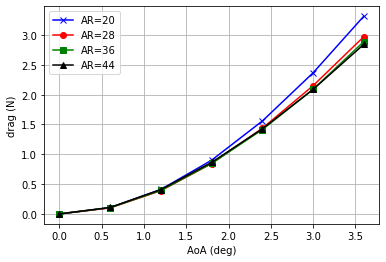

In [45]:
# Plot lift for different AR's
x = AoA_deg[0:7]
drag0 = drag[0:7]
drag1 = drag[7:14]
drag2 = drag[14:21]
drag3 = drag[21:28]
drag4 = drag[28:35]
drag5 = drag[35:42]
drag6 = drag[42:49]

fig4, ax = plt.subplots()

ax.plot(x,drag0,'bx-')
ax.plot(x,drag2,'ro-')
ax.plot(x,drag4,'gs-')
ax.plot(x,drag6,'k^-')


ax.legend(["AR=20","AR=28","AR=36","AR=44"])
ax.grid(True)
ax.set_ylabel('drag (N)')
ax.set_xlabel('AoA (deg)')

In [46]:
kx = 3 # Variation of drag with AoA
ky = 4 # Variation of drag with twist
b2 = polynomial_basis2D(x1,x2,kx,ky)
theta_drag = eval_parameter(drag[i_train],b2)

In [47]:
drag0surr = eval_surrogate(theta_drag,xp,yp0,kx,ky)
drag1surr = eval_surrogate(theta_drag,xp,yp1,kx,ky)
drag2surr = eval_surrogate(theta_drag,xp,yp2,kx,ky)
drag3surr = eval_surrogate(theta_drag,xp,yp3,kx,ky)
drag4surr = eval_surrogate(theta_drag,xp,yp4,kx,ky)
drag5surr = eval_surrogate(theta_drag,xp,yp5,kx,ky)
drag6surr = eval_surrogate(theta_drag,xp,yp6,kx,ky)

Text(0.5, 0, 'AoA (deg)')

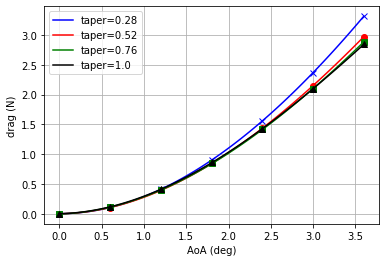

In [48]:
# Plot lift for different AR's
x = AoA_deg[0:7]

fig5, ax = plt.subplots()

ax.plot(x,drag0,'bx',label='_nolegend_')
ax.plot(xp,drag0surr,'b-')
ax.plot(x,drag2,'ro',label='_nolegend_')
ax.plot(xp,drag2surr,'r-')
ax.plot(x,drag4,'gs',label='_nolegend_')
ax.plot(xp,drag4surr,'g-')
ax.plot(x,drag6,'k^',label='_nolegend_')
ax.plot(xp,drag6surr,'k-')

ax.legend(["taper=0.28","taper=0.52","taper=0.76","taper=1.0"])
ax.grid(True)
ax.set_ylabel('drag (N)')
ax.set_xlabel('AoA (deg)')

In [49]:
error_drag = eval_error(drag[i_test],theta_drag,x1_test,x2_test,kx,ky)
print('error_drag = ',error_drag)

error_drag =  6.714600141851901e-05


In [50]:
# Use pandas as a method of saving the surrogate
def save_surrogate(kx,ky,theta,filename):
    """ Function to save the parameters of a 2D surrogate
    
    Args:
        kx        (int): Degree polynomial in variable x
        ky        (int): Degree polynomial in varibale y
        theta(np.array): Array with coefficients to evaluate surrogate
        filename  (str): String with name of file to save parameters to
    Returns:
        
    """

    b = np.zeros([(kx+1)*(ky+1),],dtype=object)
    w = np.zeros([(kx+1)*(ky+1),])
    counter = 0
    for i in range(kx+1):
        for j in range(ky+1):
            b[counter] = str('x^'+str(i)+'*'+'y^'+str(j))
            w[counter] = theta[counter]
            counter+=1
            
    # Save the basis and the corresponding parameters (theta) in a csv file using pandas
    data = {
        "basis": b,
        "theta": w
    }
    data_pandas = pd.DataFrame(data)
    data_pandas.to_csv(filename+'.csv')
    return b
    
    

In [52]:
# Change directory
kx_lift = 2
ky_lift = 4
kx_drag = 3
ky_drag = 4
os.chdir(cwd+'/'+'surrogate_built'+'/')
b = save_surrogate(kx_lift,ky_lift,theta,'lift_aoa_taper_surr_v1')
b_drag = save_surrogate(kx_drag,ky_drag,theta_drag,'drag_aoa_taper_surr_v1')
os.chdir(cwd)

## Comparison of Lift, drag and my for a stiff wing

Text(0.5, 0, 'AoA (deg)')

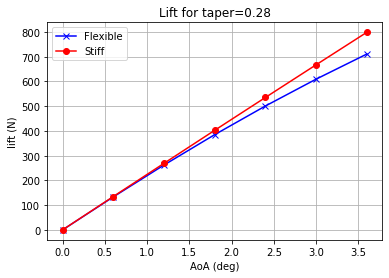

In [30]:
foldername = 'aoa_taper_stiff_forces'
cwd = os.getcwd()
os.chdir(cwd+'/'+foldername+'/')
data_stiff_pandas = pd.read_csv(foldername+'.csv') 
# Go back to the initial folder
os.chdir(cwd)
# Get the data
data_stiff_numpy = data_stiff_pandas.to_numpy()
lift_stiff = data_stiff_numpy[:,5]
drag_stiff = data_stiff_numpy[:,6]
my_stiff   = data_stiff_numpy[:,7]



lift_stiff0 = lift_stiff[0:7]
lift_stiff1 = lift_stiff[7:14]
lift_stiff2 = lift_stiff[14:21]
lift_stiff3 = lift_stiff[21:28]
lift_stiff4 = lift_stiff[28:35]
lift_stiff5 = lift_stiff[35:42]
lift_stiff6 = lift_stiff[42:49] 

drag_stiff0 = drag_stiff[0:7]
drag_stiff1 = drag_stiff[7:14]
drag_stiff2 = drag_stiff[14:21]
drag_stiff3 = drag_stiff[21:28]
drag_stiff4 = drag_stiff[28:35]
drag_stiff5 = drag_stiff[35:42]
drag_stiff6 = drag_stiff[42:49] 

my_stiff0 = my_stiff[0:7]
my_stiff1 = my_stiff[7:14]
my_stiff2 = my_stiff[14:21]
my_stiff3 = my_stiff[21:28]
my_stiff4 = my_stiff[28:35]
my_stiff5 = my_stiff[35:42]
my_stiff6 = my_stiff[42:49] 

fig3_1, ax = plt.subplots()

ax.plot(x,lift0,'bx-')
ax.plot(x,lift_stiff2,'ro-')


ax.legend(["Flexible","Stiff","Analytic"])
plt.title('Lift for taper=0.28')
ax.grid(True)
ax.set_ylabel('lift (N)')
ax.set_xlabel('AoA (deg)')


Text(0.5, 0, 'AoA (deg)')

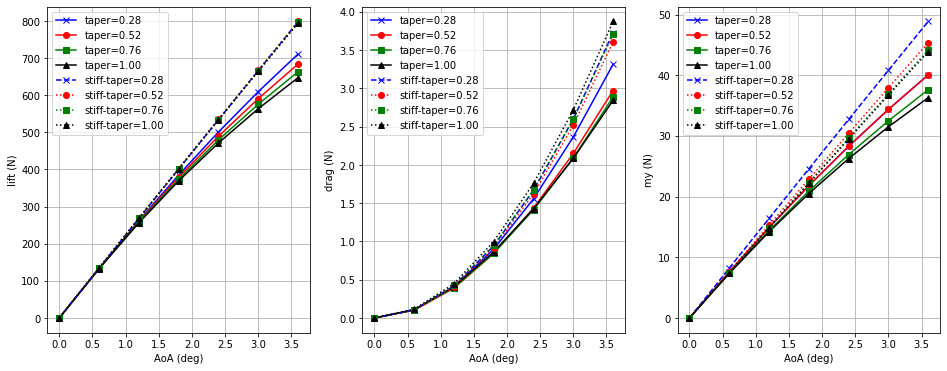

In [31]:
fig2, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

ax[0].plot(x,lift0,'bx-')
ax[0].plot(x,lift2,'ro-')
ax[0].plot(x,lift4,'gs-')
ax[0].plot(x,lift6,'k^-')

ax[0].plot(x,lift_stiff0,'bx--')
ax[0].plot(x,lift_stiff2,'ro:')
ax[0].plot(x,lift_stiff4,'gs:')
ax[0].plot(x,lift_stiff6,'k^:')



ax[0].legend(["taper=0.28","taper=0.52","taper=0.76","taper=1.00",
              "stiff-taper=0.28","stiff-taper=0.52","stiff-taper=0.76",
              "stiff-taper=1.00"])
ax[0].grid(True)
ax[0].set_ylabel('lift (N)')
ax[0].set_xlabel('AoA (deg)')


ax[1].plot(x,drag0,'bx-')
ax[1].plot(x,drag2,'ro-')
ax[1].plot(x,drag4,'gs-')
ax[1].plot(x,drag6,'k^-')

ax[1].plot(x,drag_stiff0,'bx--')
ax[1].plot(x,drag_stiff2,'ro:')
ax[1].plot(x,drag_stiff4,'gs:')
ax[1].plot(x,drag_stiff6,'k^:')

ax[1].legend(["taper=0.28","taper=0.52","taper=0.76","taper=1.00",
              "stiff-taper=0.28","stiff-taper=0.52","stiff-taper=0.76",
              "stiff-taper=1.00"])
ax[1].grid(True)
ax[1].set_ylabel('drag (N)')
ax[1].set_xlabel('AoA (deg)')

ax[2].plot(x,my2,'bx-')
ax[2].plot(x,my2,'ro-')
ax[2].plot(x,my4,'gs-')
ax[2].plot(x,my6,'k^-')

ax[2].plot(x,my_stiff0,'bx--')
ax[2].plot(x,my_stiff2,'ro:')
ax[2].plot(x,my_stiff4,'gs:')
ax[2].plot(x,my_stiff6,'k^:')

ax[2].legend(["taper=0.28","taper=0.52","taper=0.76","taper=1.00",
              "stiff-taper=0.28","stiff-taper=0.52","stiff-taper=0.76",
              "stiff-taper=1.00"])
ax[2].grid(True)
ax[2].set_ylabel('my (N)')
ax[2].set_xlabel('AoA (deg)')
